# Extraction of TDA bar codes, bar features and bottleneck distance of null models and data

## Initialization

In [1]:
# General
import os, glob, time, pickle, re
from copy import deepcopy
from functools import partial

# For progress + multipleprocessing 
from p_tqdm import p_map
from tqdm.notebook import tqdm

# General computation
import numpy as np 
from sklearn.metrics import pairwise_distances as pw_dist
from scipy.spatial.distance import squareform
from scipy.stats import entropy
import networkx as nx

# TDA packages
import gudhi as gd

# Import from src 
from src.utils import *
from src.tda import *


In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
import seaborn as sns

%matplotlib inline

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 20

rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2 

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'
rcParams['figure.dpi'] = 200


## 1. Extract from null models **with** edge density

### 1.1. Generate geometric matrices

#### Demo example

In [3]:
max_k = 4 
vec_rhos = np.linspace(0,0.8,3000)

N = 78 
d = 20

X = np.random.uniform(size=(N,d))
dX = pw_dist(X, metric='euclidean')  
bar_feats_demo = process_Dmatrix(dX, max_k, vec_rhos)

parent_keys = list(bar_feats_demo.keys())
feat_keys = list(bar_feats_demo[parent_keys[0]].keys())

In [4]:
parent_keys = list(bar_feats_demo.keys())
feat_keys = list(bar_feats_demo[parent_keys[0]].keys())

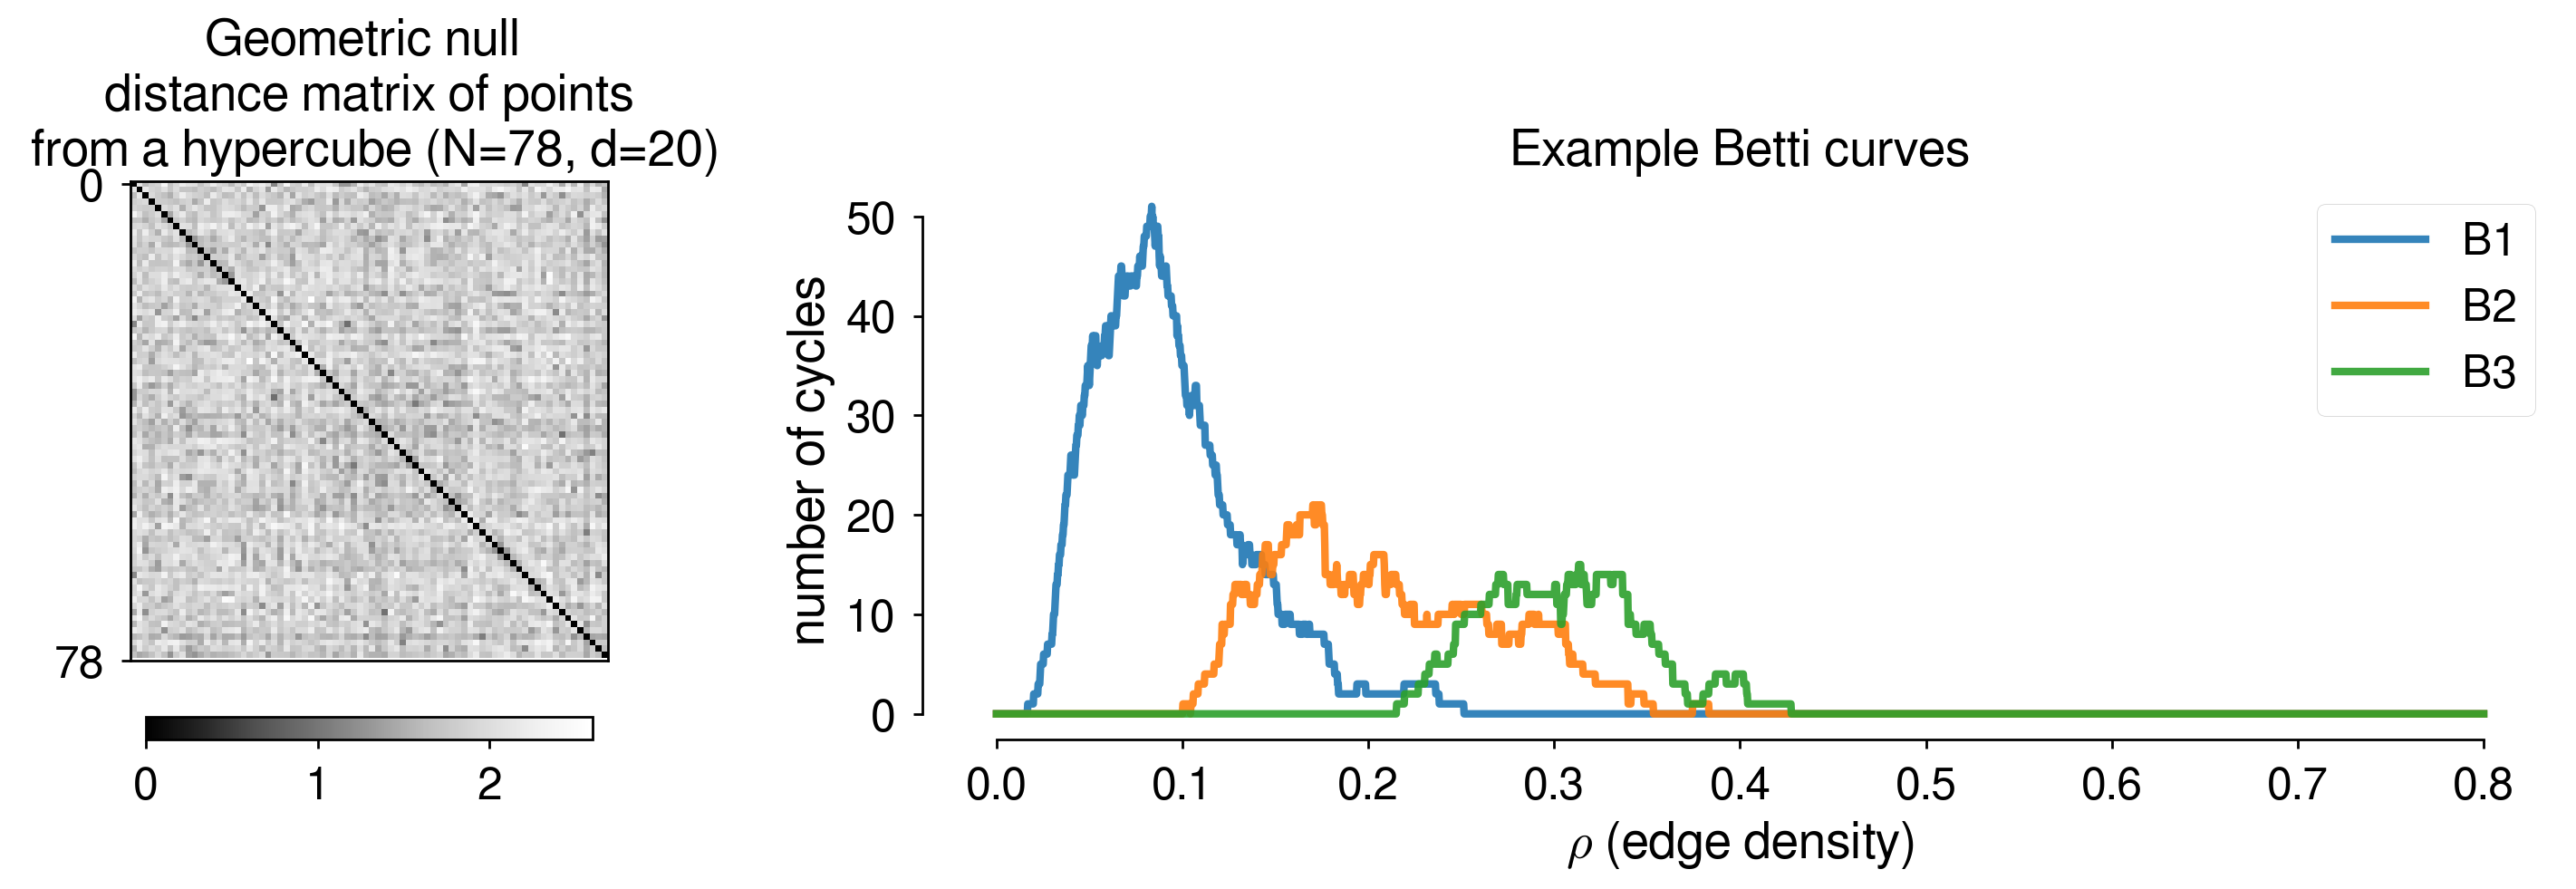

In [72]:
plt.figure(figsize=(18,4))

betti_styles = {'B1': ':', 'B2': '--', 'B3': '-'}

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=3)

im = ax1.imshow(dX, cmap='Greys_r')
plt.colorbar(im, ax=ax1, fraction=0.04, pad=0.1, orientation='horizontal')
ax1.set_title('Geometric null \n distance matrix of points \n from a hypercube (N=%d, d=%d)' %(N,d))
ax1.set_yticks([0,N]) 
ax1.set_xticks([])
ax2_pos = list(ax2.get_position().bounds)
ax2_pos[0] += 0.01
ax2.set_position(ax2_pos)
[ax2.plot(vec_rhos,v['betti_num'],lw=3,label=k,alpha=0.9)
 for k,v in bar_feats_demo.items()]
plt.legend()
plt.title('Example Betti curves')
plt.xlabel('$\\rho$ (edge density)')
plt.ylabel('number of cycles')
sns.despine(trim=True,ax=ax2)
plt.show()

#### Generate a population of geometric matrices

In [6]:
num_samples = 78 # matching the number of ROIs
dim_vec = [2,3,5,7,10,20,40,60,num_samples] 
num_gen = 30
max_k = 4 
vec_rhos = np.linspace(0,0.8,3000)
num_cpus = 5

geom_barfeats_and_barcodes = {}       
        
def get_barfeats_geommodel(_,dim):
    X = np.random.uniform(size=(num_samples,dim))
    dX = pw_dist(X, metric='euclidean')  
    return process_Dmatrix(dX, max_k=max_k, vec_rhos=vec_rhos,
                          min_k=1, process_edgedensity=True, save_barcodes=True)
for dim in dim_vec:
    print('Generating geom model dim = %d for %d times' %(dim, num_gen))
    geom_barfeats_and_barcodes[dim] = p_map(partial(get_barfeats_geommodel,dim=dim),
                                            np.arange(num_gen),num_cpus=num_cpus)  
    
geom_barfeats = {k:concat_barfeats([x['barfeats'] for x in v],parent_keys,feat_keys) 
                 for k,v in geom_barfeats_and_barcodes.items()}
geom_barcodes = {k:[x['barcodes'] for x in v] for k,v in geom_barfeats_and_barcodes.items()}

Generating geom model dim = 2 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 3 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 5 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 7 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 10 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 20 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 40 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 60 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating geom model dim = 78 for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
proc_path = 'data/processed/'
data_file_pref = 'geom-pershom'
with open(proc_path + data_file_pref + '.pkl','wb') as f:
    pickle.dump(dict(
        barfeats = geom_barfeats, 
        barcodes = geom_barcodes,
        num_samples = num_samples, 
        dim_vec = dim_vec, 
        num_gen = num_gen, 
        max_k = max_k, 
        vec_rhos = vec_rhos, 
        parent_keys = parent_keys, 
        feat_keys = feat_keys        
    ),f)

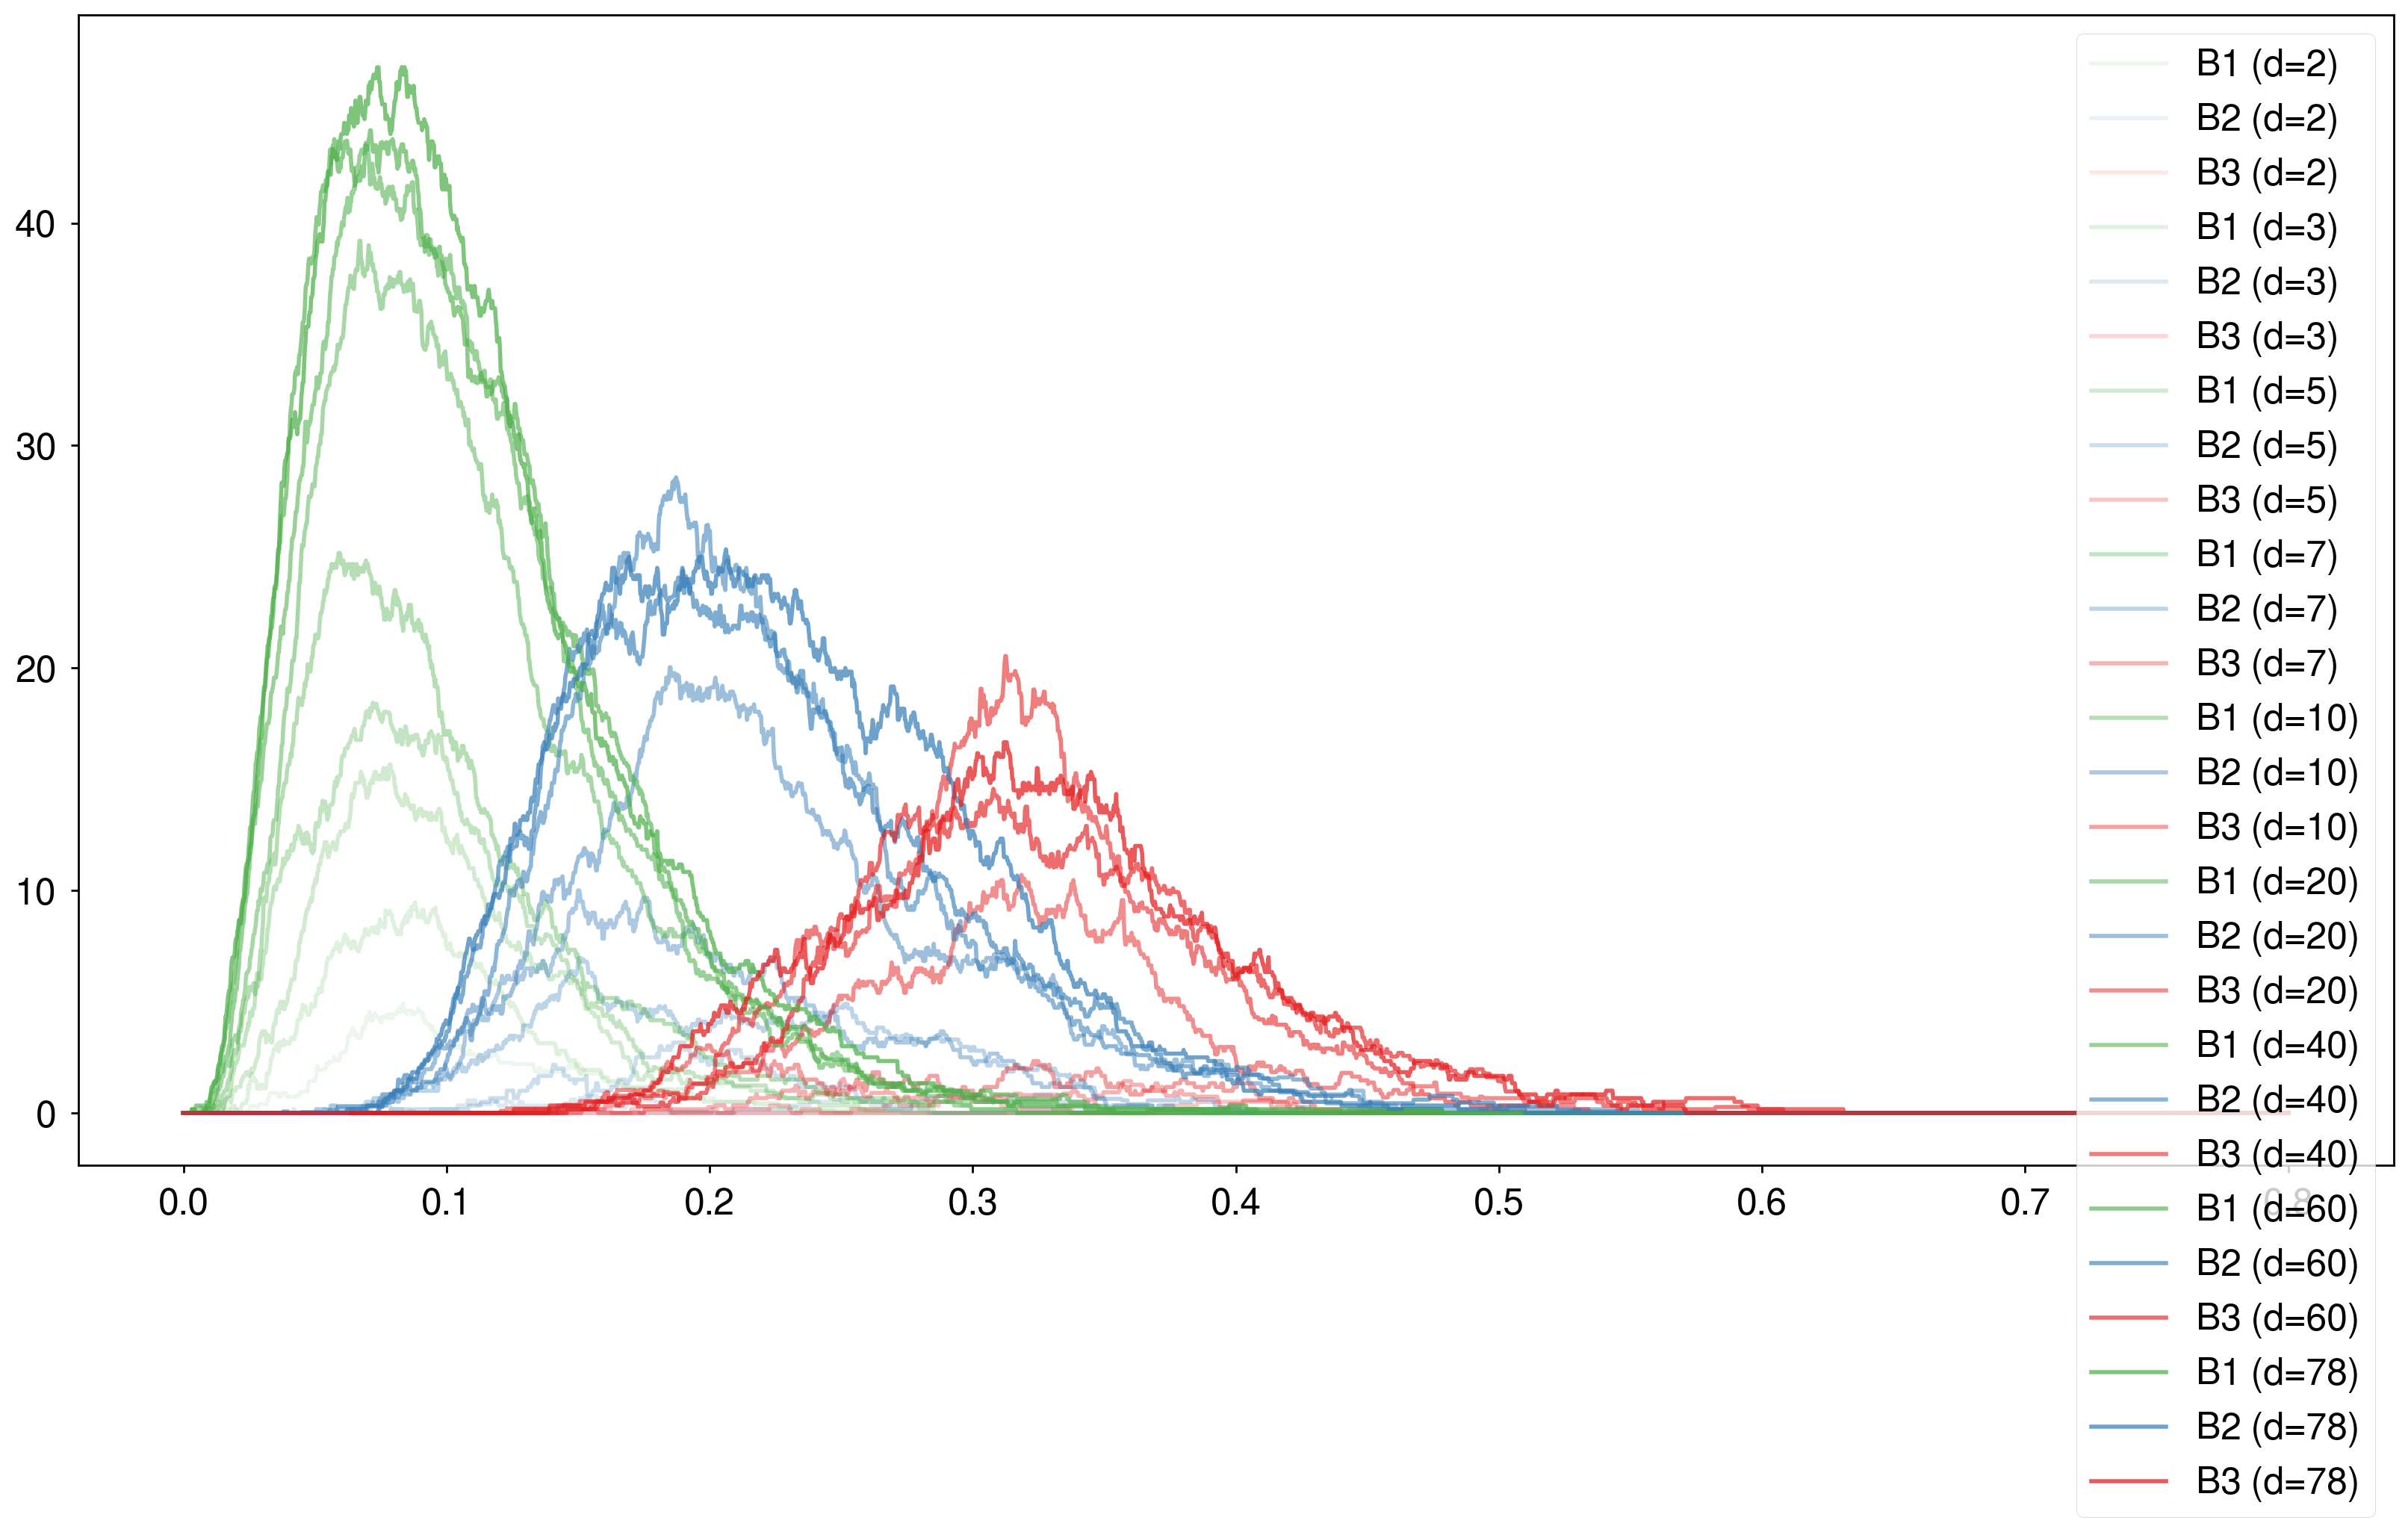

In [9]:
plt.figure(figsize=(20,10))

num_dims = len(geom_barfeats)
betti_colors = {'B1': [0.30196078, 0.68627451, 0.29019608], 
                'B2': [0.21568627, 0.49411765, 0.72156863],
                'B3': [0.89411765, 0.10196078, 0.10980392]}


for cnt, (dim, bar_feats) in enumerate(geom_barfeats.items()):
    [plt.plot(vec_rhos,np.mean(v['betti_num'],axis=0),
              c=betti_colors[k],
              label='%s (d=%d)' %(k,dim),
              alpha=0.1+0.7*(cnt/num_dims))
     for k,v in bar_feats.items()]
plt.legend()
plt.show()

### 1.2 Generate (dis)assortative networks with block models

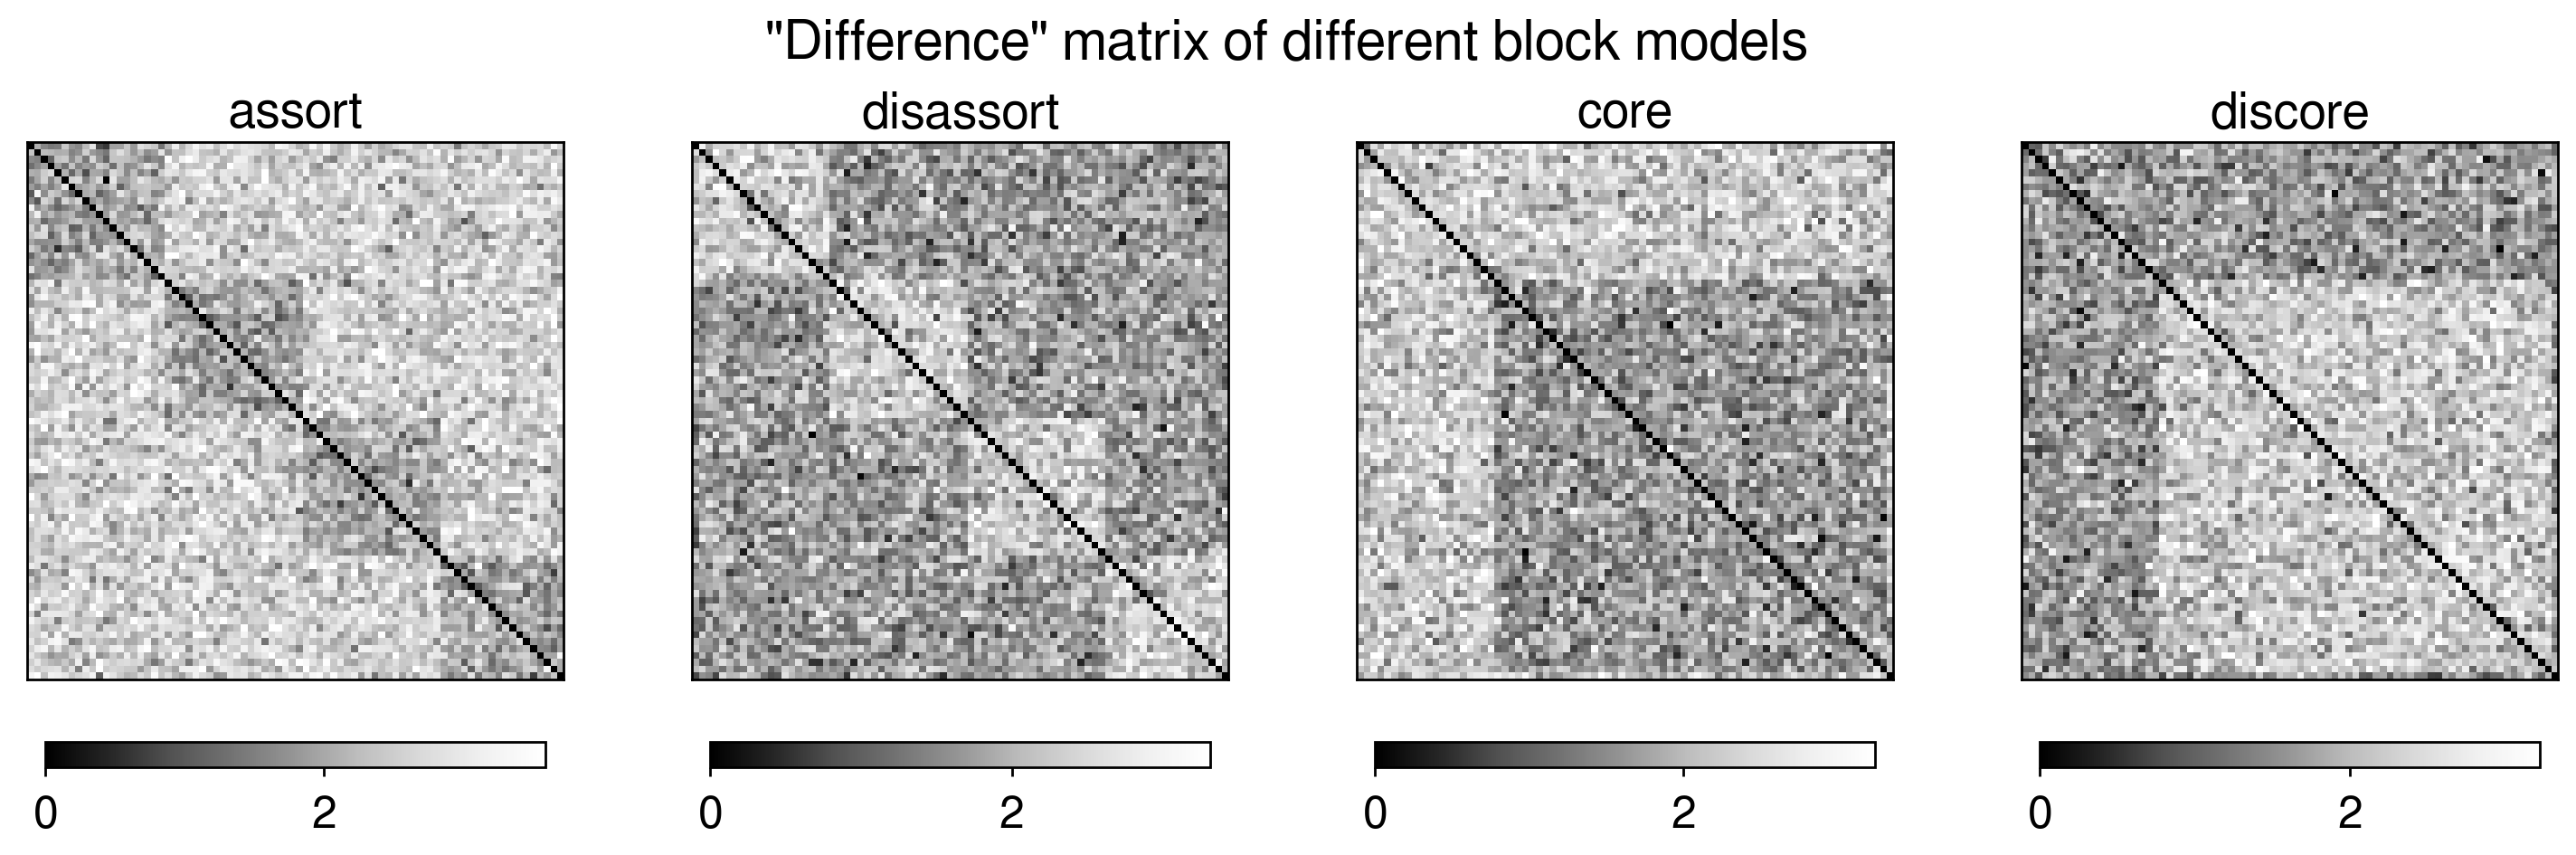

In [73]:
sbm_types = ['assort', 'disassort', 'core', 'discore']

plt.figure(figsize=(15,5))

for cnt,mod_type in enumerate(sbm_types):
    plt.subplot(1,len(sbm_types),cnt+1)
    D = gen_wsbm(78,model_type=mod_type,mu_high=1.6)
    im = plt.imshow(D, cmap='Greys_r')
    plt.title(mod_type)
    plt.colorbar(im, fraction=0.04, pad=0.1, orientation='horizontal')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('"Difference" matrix of different block models', y=0.96,fontsize=22)
plt.tight_layout()
plt.show()

In [10]:
proc_path = 'data/processed/'
pershom_file_pref = 'block-pershom'
num_gen = 30
num_cpus = 5
N = 78
mu_high = 1.6

max_k = 4
vec_rhos = np.linspace(0,0.8,3000) 

def get_barfeats_blockmodel(_,model_type):
    D_mat = gen_wsbm(N, model_type=model_type,mu_high=mu_high)
    return process_Dmatrix(D_mat, max_k, vec_rhos,
                           min_k=1, process_edgedensity=True, save_barcodes=True)

blockmod_barfeats = {} 
blockmod_barcodes = {} 
for model_type in sbm_types:
    print('Generating block model type = "%s" for %d times' %(model_type, num_gen))
    barfeats_and_barcodes_list = p_map(partial(get_barfeats_blockmodel, model_type=model_type), 
                                       np.arange(num_gen),num_cpus=5)
    blockmod_barfeats[model_type] = concat_barfeats([x['barfeats'] for x in barfeats_and_barcodes_list],
                                                    parent_keys,feat_keys)
    blockmod_barcodes[model_type] = [x['barcodes'] for x in barfeats_and_barcodes_list]


Generating block model type = "assort" for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating block model type = "disassort" for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating block model type = "core" for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

Generating block model type = "discore" for 30 times


  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
proc_path = 'data/processed/'

with open(proc_path + pershom_file_pref + '.pkl','wb') as f:
    pickle.dump(dict(
        barfeats = blockmod_barfeats, 
        barcodes = blockmod_barcodes,
        max_k = max_k, 
        vec_rhos = vec_rhos,  
        num_gen = num_gen,
        model_types = sbm_types,
        model_params = dict(mu_high=mu_high)
    ),f)


## 2. Extract from data matrices **with** edge density

### 2.1. Original data

In [74]:
max_k = 4 
vec_rhos = np.linspace(0,0.8,3000)

In [75]:
preproc_path = 'data/preprocessed/' 
data_file_pref = 'multisensory-measures-'

with open(preproc_path + data_file_pref + 'info.pkl','rb') as f:
    meta_info = pickle.load(f)

display(meta_info['info']['measures_path'])

{'mutual_info': 'data/preprocessed/multisensory-measures-mutual_info.npz',
 'var_info': 'data/preprocessed/multisensory-measures-var_info.npz',
 'corr_coef': 'data/preprocessed/multisensory-measures-corr_coef.npz',
 'corr_dist': 'data/preprocessed/multisensory-measures-corr_dist.npz'}

In [ ]:
dX_source = meta_info['info']['measures_path']['var_info']
dXs = np.load(dX_source)['X']
barfeats_data_demo = process_Dmatrix(dXs[39], max_k, vec_rhos)

In [92]:
dX_demo_orig = dXs[39]
dX_demo_shuf = squareform(np.random.permutation(squareform(dX_demo_orig,checks=False)))
barfeats_data_demo_orig = process_Dmatrix(dX_demo_orig, max_k, vec_rhos)
barfeats_data_demo_shuf = process_Dmatrix(dX_demo_shuf, max_k, vec_rhos)

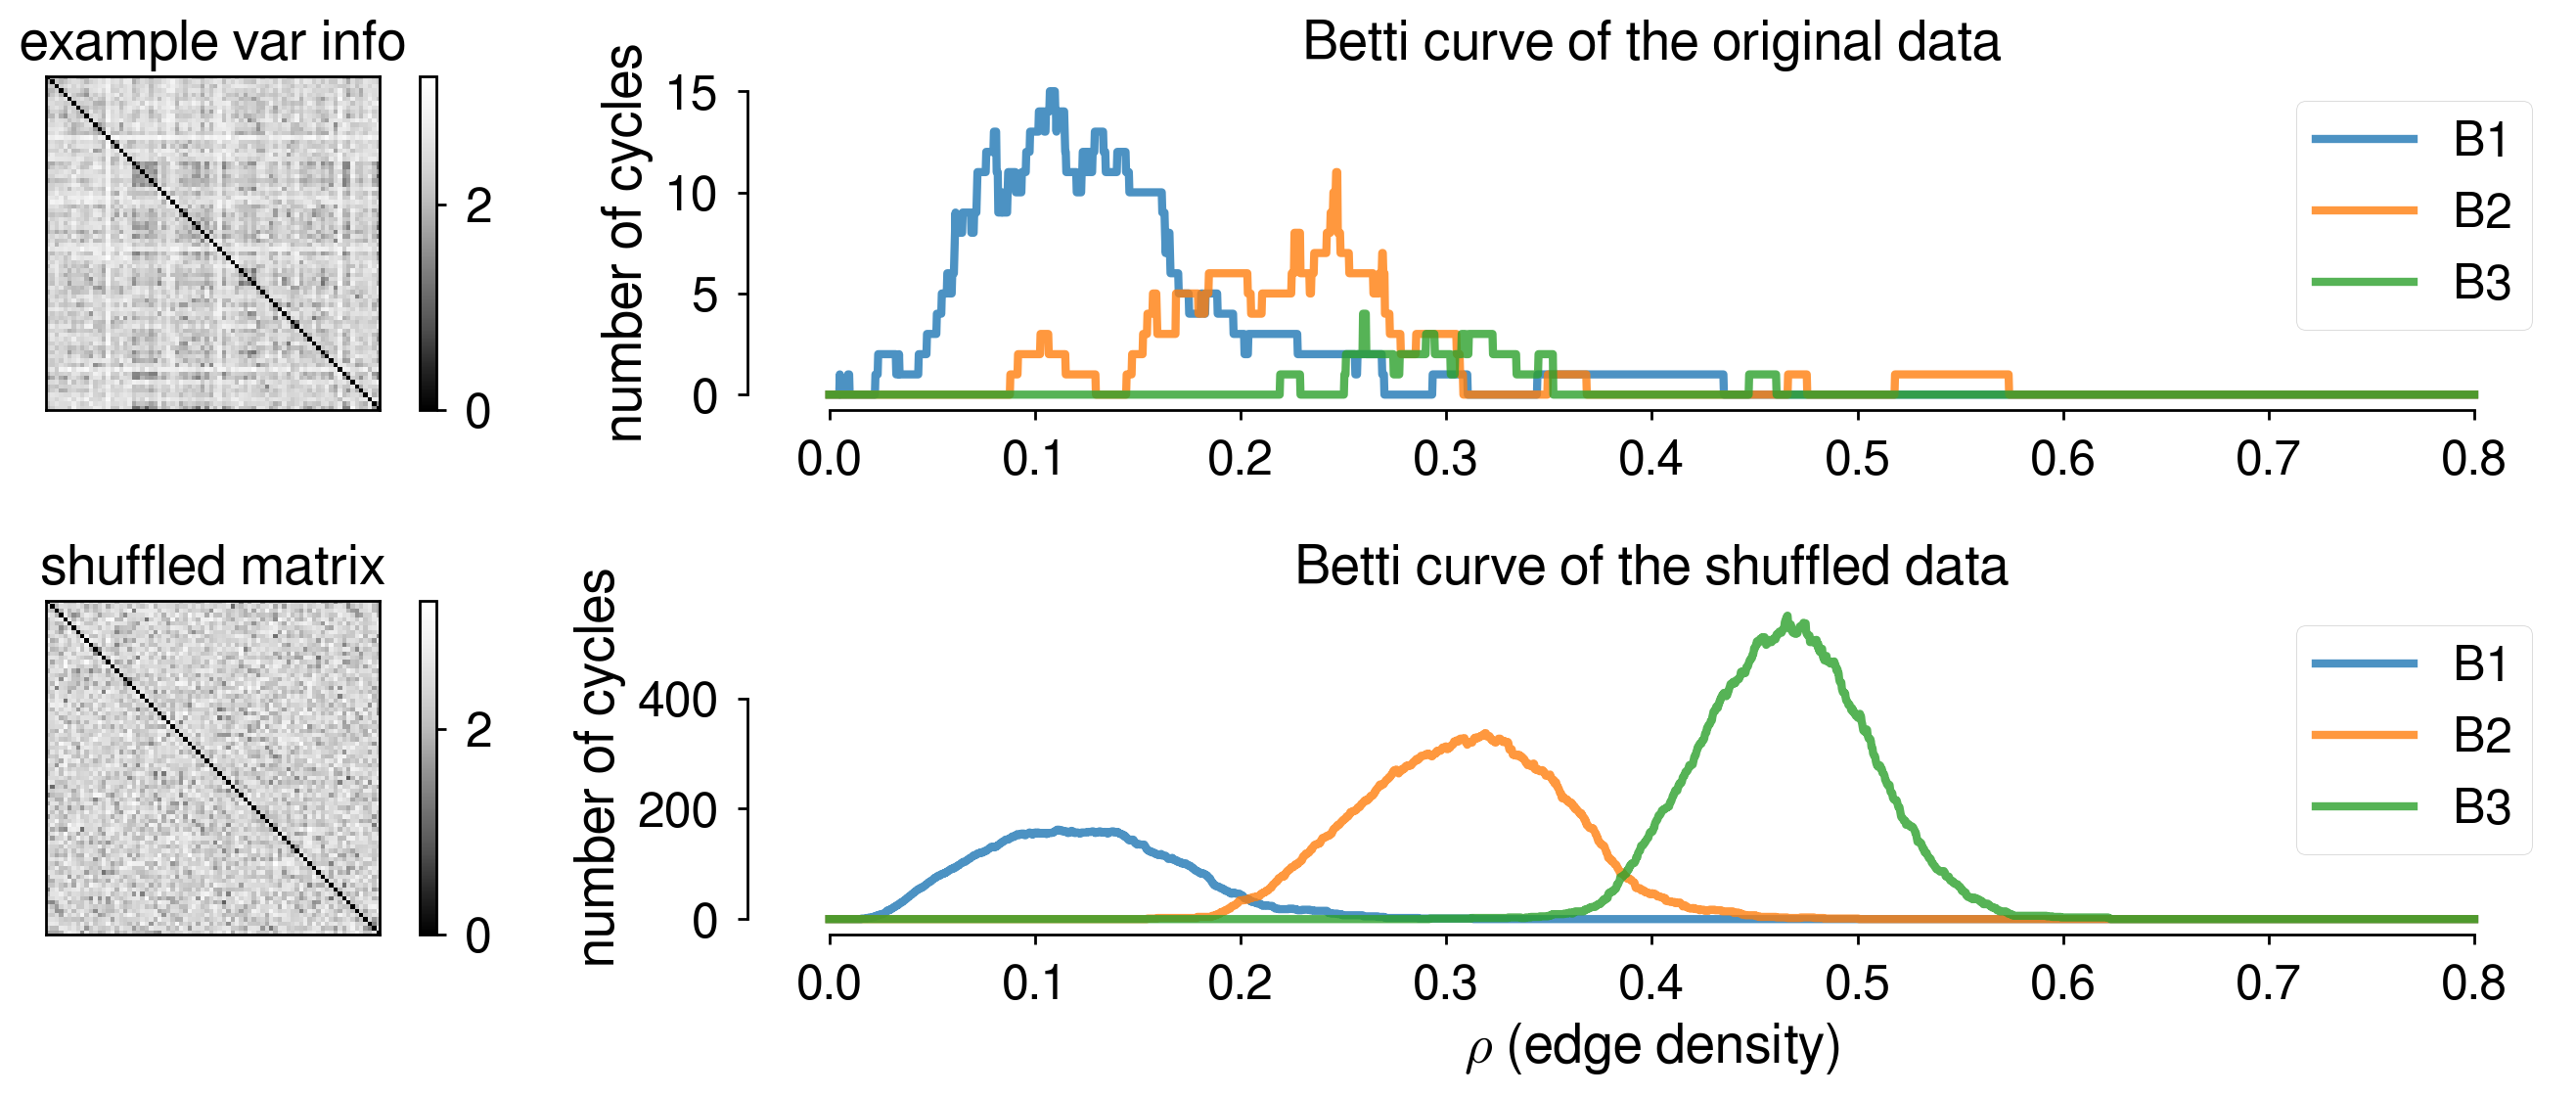

In [118]:
plt.figure(figsize=(15,6))

plt.subplot2grid((2, 3), (0, 0))
plt.imshow(dX_demo_orig, cmap='Greys_r')
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.title('example var info')

ax1 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
[plt.plot(vec_rhos,v['betti_num'],label='%s' %(k),alpha=0.8,lw=3) for k,v in barfeats_data_demo_orig.items()]
plt.ylabel('number of cycles')
plt.title('Betti curve of the original data')
plt.legend()

plt.subplot2grid((2, 3), (1, 0))
plt.imshow(dX_demo_shuf, cmap='Greys_r')
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.title('shuffled matrix')

ax2 = plt.subplot2grid((2, 3), (1, 1), colspan=3)

[plt.plot(vec_rhos,v['betti_num'],label='%s' %(k),alpha=0.8,lw=3) for k,v in barfeats_data_demo_shuf.items()]
plt.xlabel('$\\rho$ (edge density)')
plt.ylabel('number of cycles')
plt.title('Betti curve of the shuffled data')
plt.legend()

[sns.despine(trim=True, ax = ax) for ax in [ax1,ax2]]

plt.tight_layout()
plt.show()

In [15]:
pershom_file_pref = 'multisensory-pershom-original-pertrial-withedgedensity-'

select_measure_list = ['corr_dist', 'var_info']
num_cpus = 5
for measure_name in select_measure_list:
    
    dX_source = meta_info['info']['measures_path'][measure_name]
    dXs = np.load(dX_source)['X']
    
    print('Processing "%s" matrix from file "%s"' %(measure_name, dX_source))
    
    data_barfeats = p_map(partial(process_Dmatrix, 
                                  max_k=max_k, 
                                  vec_rhos=vec_rhos, 
                                  min_k=1,
                                  process_edgedensity=True,
                                  save_barcodes=True), 
                          [dX for dX in dXs], num_cpus=num_cpus)

    with open(proc_path + pershom_file_pref + measure_name + '.pkl','wb') as f:
        pickle.dump(dict(
            barfeats = [x['barfeats'] for x in data_barfeats], 
            barcodes = [x['barcodes'] for x in data_barfeats], 
            max_k = max_k, 
            vec_rhos = vec_rhos,  
            data_source=dX_source,
            note='unconcatenated'
        ),f)
        

Processing "corr_dist" matrix from file "data/preprocessed/multisensory-measures-corr_dist.npz"


  0%|          | 0/125 [00:00<?, ?it/s]

Processing "var_info" matrix from file "data/preprocessed/multisensory-measures-var_info.npz"


  0%|          | 0/125 [00:00<?, ?it/s]

### 2.2. Shuffled data 

In [16]:
pershom_file_pref = 'multisensory-pershom-shuffled-pertrial-withedgedensity-'
num_shuffles = 3
select_measure_list = ['corr_dist', 'var_info']
num_cpus = 5

def get_barfeats_shuffled(dX):
    shuff_barfeat_collection = []
    for _ in range(num_shuffles):
        dX_shuffled = squareform(np.random.permutation(squareform(dX,checks=False)))
        shuff_barfeat_collection.append(process_Dmatrix(dX_shuffled, max_k, vec_rhos, 
                                                        min_k=1,
                                                        process_edgedensity=True,
                                                        save_barcodes=False))    
    return shuff_barfeat_collection

for measure_name in select_measure_list:
    dX_source = meta_info['info']['measures_path'][measure_name]
    dXs = np.load(dX_source)['X']
    
    print('Processing shuffled "%s" matrix with (num-shuff=%d) from file "%s"' 
          %(measure_name, num_shuffles, dX_source))
    
    shuff_barfeats = p_map(get_barfeats_shuffled, [dX for dX in dXs], num_cpus=num_cpus)

    with open(proc_path + pershom_file_pref + measure_name + '.pkl','wb') as f:
        pickle.dump(dict(
            barfeats = shuff_barfeats, 
            max_k = max_k, 
            vec_rhos = vec_rhos,  
            data_source=dX_source,
            note='unconcatenated with stim'
        ),f)
        

Processing shuffled "corr_dist" matrix with (num-shuff=3) from file "data/preprocessed/multisensory-measures-corr_dist.npz"


  0%|          | 0/125 [00:00<?, ?it/s]

Processing shuffled "var_info" matrix with (num-shuff=3) from file "data/preprocessed/multisensory-measures-var_info.npz"


  0%|          | 0/125 [00:00<?, ?it/s]

### 2.3. Combine with stimulus info in data related TDA files

In [17]:
stim_path = 'data/preprocessed/purkpop-stim.pkl'
proc_path = 'data/processed/'
data_pershom = glob.glob(proc_path + 'multisensory-pershom-*-pertrial-withedgedensity*.pkl')

with open(stim_path, 'rb') as f: 
    stim_info = pickle.load(f)
    
stim_type_vec = stim_info['stim_types']
unq_stim_types = ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'] # manual sort
stim_type_ind = {k:np.where(stim_type_vec == k)[0] for k in unq_stim_types}
    
parent_keys = list(barfeats_data_demo.keys())
feat_keys = list(barfeats_data_demo[parent_keys[0]].keys())

for pershom_pertrial_file in data_pershom: 
    with open(pershom_pertrial_file, 'rb') as f: 
        bar_feats = pickle.load(f)
     
    if 'original' in pershom_pertrial_file:
        bar_feats['barfeats'] = {k:
                                 concat_barfeats(
                                     get_list_at(bar_feats['barfeats'],v),
                                     parent_keys,feat_keys) 
                                 for k,v in stim_type_ind.items()}
    if 'shuffled' in pershom_pertrial_file:
        bar_feats['barfeats'] = {k:
                                 concat_barfeats(
                                     flatten_list(get_list_at(bar_feats['barfeats'],v)),
                                     parent_keys,feat_keys) 
                                 for k,v in stim_type_ind.items()}
    bar_feats['data_source'] += '\n' + pershom_pertrial_file + '\n' + stim_path
    bar_feats['note'] = 'stimulus sorted'
    
    with open(re.sub('pertrial-', '', pershom_pertrial_file), 'wb') as f: 
        pickle.dump(bar_feats, f)

### 2.4. Compute bottleneck distances between data and a nulls

In [3]:
stim_path = 'data/preprocessed/purkpop-stim.pkl'

with open(stim_path, 'rb') as f: 
    stim_info = pickle.load(f)
    
stim_type_vec = stim_info['stim_types']
unq_stim_types = ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'] # manual sort
stim_type_ind = {k:np.where(stim_type_vec == k)[0] for k in unq_stim_types}

In [5]:
proc_path = 'data/processed/'
sum_path = 'data/summary/'

null_files = dict(
    geom = 'geom-pershom.pkl',
    block = 'block-pershom.pkl'
)
null_select = dict(
    geom = [2,3,5,7,10,20],
    block = 'all', 
)
data_files = dict(
    var_info = 'multisensory-pershom-original-withedgedensity-var_info.pkl', 
    corr_dist = 'multisensory-pershom-original-withedgedensity-corr_dist.pkl'
)

In [6]:
file_name_pref = 'pairwise-bottleneck-withedgedensity-'

for dat_key,dat_file in data_files.items():
    
    barcodes_concat = {}
    barcodes_labels = {}

    with open(proc_path + dat_file, 'rb') as f:
        barcodes_concat = pickle.load(f)['barcodes']
        barcodes_labels = stim_type_ind

    curr_nitems = len(barcodes_concat)
    for null_key,null_fname in null_files.items(): 
        with open(proc_path + null_fname, 'rb') as f:
            barcodes_nulls = pickle.load(f)
            num_gen = barcodes_nulls['num_gen']
            barcodes_nulls = barcodes_nulls['barcodes']
        null_select_keys = null_select[null_key]
        if null_select_keys is not 'all':
            barcodes_nulls = {k:v for k,v in barcodes_nulls.items() if k in null_select_keys}
        null_model_keys = {'%s-%s' %(null_key, x): np.arange(num_gen) + i*num_gen + curr_nitems
                           for i,x in enumerate(barcodes_nulls.keys())}
        barcodes_labels.update(**null_model_keys)
        barcodes_concat += flatten_list(list(barcodes_nulls.values()))

        curr_nitems = len(barcodes_concat)

    persdim_keys = list(barcodes_concat[0].keys())
    pw_BN = {k:get_pairwise_bottleneck(barcodes_concat, k, diag_val=0, 
                                       label_dict=barcodes_labels,
                                       return_trial_and_label_dist=False)
             for k in tqdm(persdim_keys, desc='Data key = %s' %(dat_key))}

    with open(proc_path + file_name_pref + dat_key + '.pkl', 'wb') as f: 
        pickle.dump(dict(
            bottleneck_pairwise = pw_BN,
            source = dict(
                nulls = null_files,
                data = dat_file, 
                null_filter = null_select
            )
        ),f)

Data key = var_info:   0%|          | 0/3 [00:00<?, ?it/s]

processing B1:   0%|          | 0/424 [00:00<?, ?it/s]

processing B2:   0%|          | 0/424 [00:00<?, ?it/s]

processing B3:   0%|          | 0/424 [00:00<?, ?it/s]

Data key = corr_dist:   0%|          | 0/3 [00:00<?, ?it/s]

processing B1:   0%|          | 0/424 [00:00<?, ?it/s]

processing B2:   0%|          | 0/424 [00:00<?, ?it/s]

processing B3:   0%|          | 0/424 [00:00<?, ?it/s]

## 3. Extract from raw data **without** edge density (i.e. with data differences)

In [3]:
max_k = 4 
min_k = 0

In [4]:
preproc_path = 'data/preprocessed/' 
proc_path = 'data/processed/'
data_file_pref = 'multisensory-measures-'

with open(preproc_path + data_file_pref + 'info.pkl','rb') as f:
    meta_info = pickle.load(f)

display(meta_info['info']['measures_path'])

{'mutual_info': 'data/preprocessed/multisensory-measures-mutual_info.npz',
 'var_info': 'data/preprocessed/multisensory-measures-var_info.npz',
 'corr_coef': 'data/preprocessed/multisensory-measures-corr_coef.npz',
 'corr_dist': 'data/preprocessed/multisensory-measures-corr_dist.npz'}

### 3.1.Test with a few examples

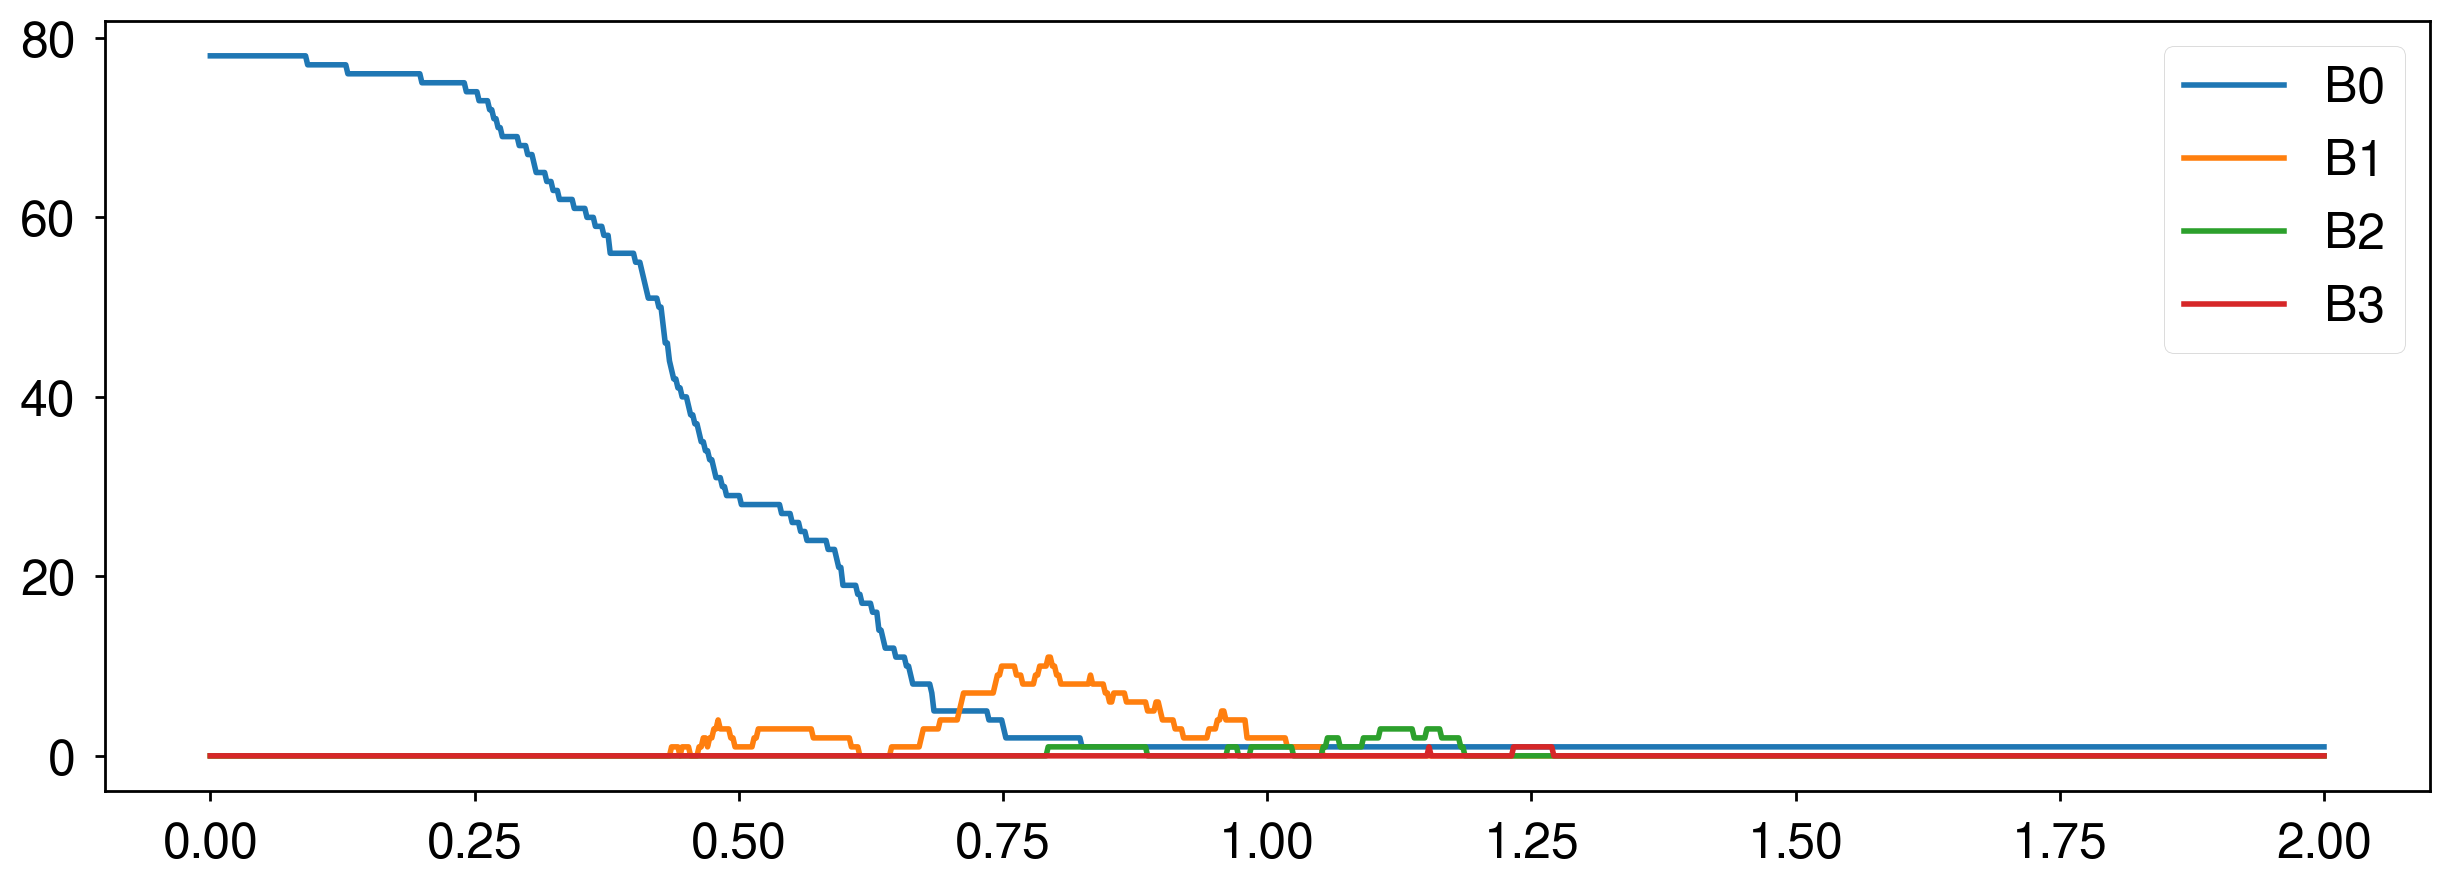

In [5]:
vec_rhos = np.linspace(0,2,1000)
dX_source = meta_info['info']['measures_path']['corr_dist']
dXs = np.load(dX_source)['X']
barfeats_data_demo = process_Dmatrix(dXs[39], max_k, vec_rhos,                     
                                     process_edgedensity=False, 
                                     min_k=min_k,save_barcodes=True)

plt.figure(figsize=(15,5))
[plt.plot(vec_rhos,v['betti_num'],label='%s' %(k)) for k,v in barfeats_data_demo['barfeats'].items()]
plt.legend()
plt.show()

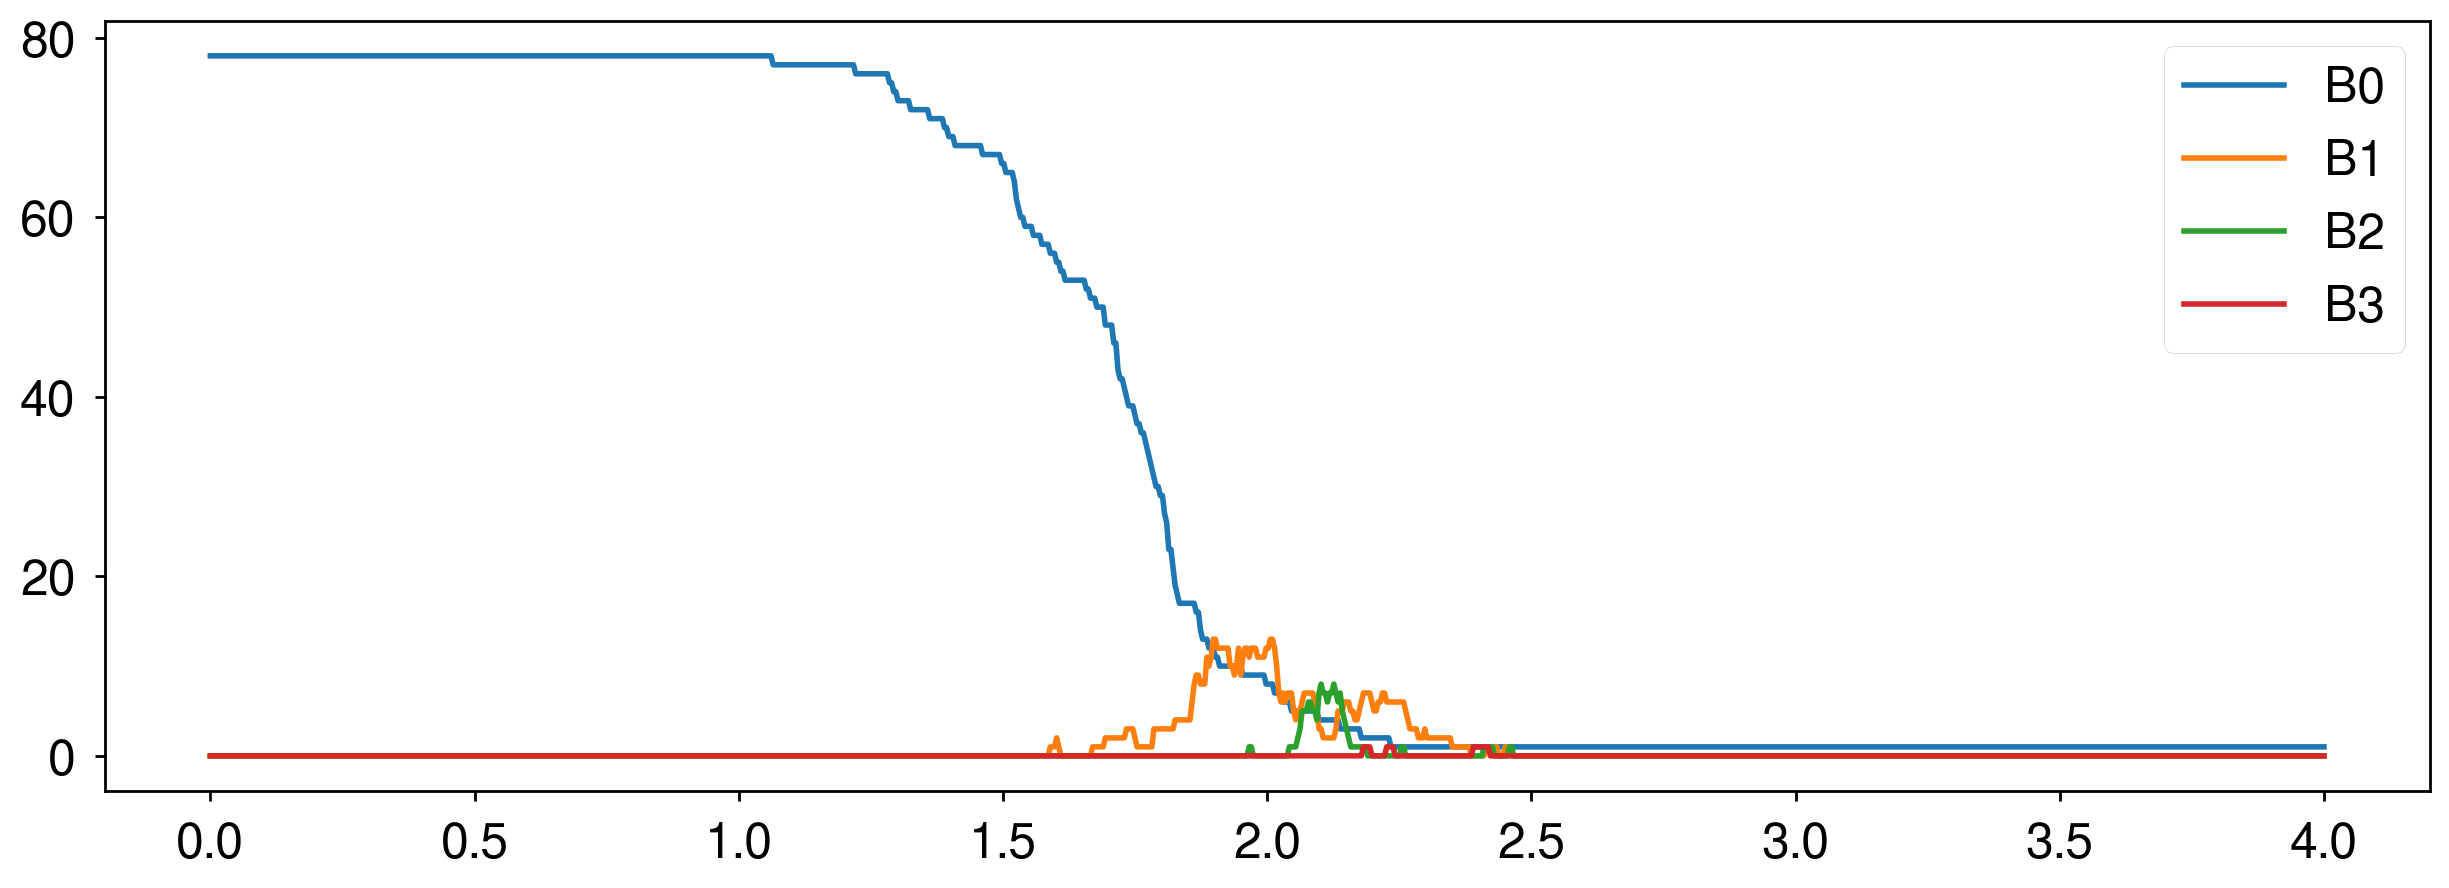

In [6]:
vec_rhos = np.linspace(0,4,1000)
dX_source = meta_info['info']['measures_path']['var_info']
dXs = np.load(dX_source)['X']
barfeats_data_demo = process_Dmatrix(dXs[9], max_k, vec_rhos, 
                                     process_edgedensity=False, 
                                     min_k=min_k,save_barcodes=True)

plt.figure(figsize=(15,5))
[plt.plot(vec_rhos,v['betti_num'],label='%s' %(k)) for k,v in barfeats_data_demo['barfeats'].items()]
plt.legend()
plt.show()

In [11]:
plot_persistent_diagrams(barcodes=barfeats_data_demo['barcodes'],
                         fig_title='example persistent barcodes and diagram (zoomed in)',
                         fig_prefix='figures/demo',
                         zoomin_range=[1,3], 
                         rho_label='var-info')

### 3.2 Go through all of them

In [8]:
pershom_file_pref = 'multisensory-pershom-original-pertrial-withdist-'
select_measure_list = ['corr_dist', 'var_info']
num_cpus = 3
max_k = 4
min_k = 0 
vec_rhos_dict = dict(
    corr_dist = np.linspace(0,2,1000),
    var_info  = np.linspace(0,4,1000),
)

for measure_name in select_measure_list:    
    dX_source = meta_info['info']['measures_path'][measure_name]
    dXs = np.load(dX_source)['X']
    
    vec_rhos = vec_rhos_dict[measure_name]
    
    print('Processing "%s" matrix from file "%s"' %(measure_name, dX_source))
    
    data_barfeats = p_map(partial(process_Dmatrix, 
                                  max_k=max_k, 
                                  vec_rhos=vec_rhos, 
                                  min_k=min_k,
                                  process_edgedensity=False,
                                  save_barcodes=True), 
                          [dX for dX in dXs], num_cpus=num_cpus)
    
    with open(proc_path + pershom_file_pref + measure_name + '.pkl','wb') as f:
        pickle.dump(dict(
            barfeats = [x['barfeats'] for x in data_barfeats],
            barcodes = [x['barcodes'] for x in data_barfeats],
            min_k = min_k,
            max_k = max_k, 
            vec_rhos = vec_rhos,  
            data_source=dX_source,
            note='process distance, not edge density'
        ),f)
    

Processing "var_info" matrix from file "data/preprocessed/multisensory-measures-var_info.npz"


  0%|          | 0/125 [00:00<?, ?it/s]

In [41]:
trial_ids = list(meta_info['info']['selection']['trial_list'])
pershom_file_pref = 'multisensory-pershom-original-pertrial-withdist-'
select_measure_list = ['corr_dist', 'var_info']
zoomin_persdgm = dict(
    corr_dist = [0.25,1.5],
    var_info  = [1,3]
)

for measure_name in select_measure_list:        
    with open(proc_path + pershom_file_pref + measure_name + '.pkl','rb') as f:
        data_barfeats = pickle.load(f)
        vec_rhos = data_barfeats['vec_rhos']
        data_barcodes = data_barfeats['barcodes']
    
    zoomin_range = zoomin_persdgm[measure_name]
    
    for x,y in tqdm(zip(data_barcodes, trial_ids), total=len(trial_ids)):
        fig_name = 'trial%03d-%s' %(y,measure_name)
        plot_persistent_diagrams(barcodes=x,
                                 fig_title=fig_name,
                                 fig_prefix='figures/persistent-diagrams/%s' %(fig_name),
                                 zoomin_range=zoomin_range) 

In [ ]:
tdafeats_file_pref = 'multisensory-tdafeats-original-pertrial-withdist-'
select_measure_list = ['corr_dist', 'var_info']

select_barfeats_patterns = ['int_betti', '[^sum]_pers', 'alg_.*_mean']
betti_curve_pattern = 'betti_num'
smooth_factor_betti = 50
skip_factor_betti = 30

def smooth(arr, span=10):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
def process_betti_curve(X,s_win=10,skip=1):
    return smooth(X,s_win)[::skip]

norm_by = 80

for measure_name in select_measure_list:        
    with open(proc_path + pershom_file_pref + measure_name + '.pkl','rb') as f:
        data_barfeats = pickle.load(f)
        vec_rhos = data_barfeats['vec_rhos']
        data_barfeats = data_barfeats['barfeats']
        
    data_barfeats = [[{'%s_%s' %(k1,k2): v2 for k2,v2 in v1.items()} 
                      for k1,v1 in x.items()] for x in data_barfeats]
    data_barfeats = [{k: v for d in x for k, v in d.items()} for x in data_barfeats]

    feat_keys = list(data_barfeats[0].keys())
    select_feats = list(filter(lambda x: re.findall('|'.join(select_barfeats_patterns),x), feat_keys))

    scalar_barfeats = [{k:v for k,v in x.items() if k in select_feats} for x in data_barfeats]
    scalar_barfeats = pd.DataFrame(scalar_barfeats).to_numpy()
    betti_curves = [{k:process_betti_curve(v,smooth_factor_betti*i,skip_factor_betti)
                     for i,(k,v) in enumerate(x.items())
                     if betti_curve_pattern in k} for x in data_barfeats]
    betti_curves = [{k:v/10**(1+(i==0)-i) for i,(k,v) in enumerate(x.items())}
                    for x in betti_curves]
    betti_curves = [np.concatenate(list(x.values())) for x in betti_curves]
    with open(proc_path + tdafeats_file_pref + measure_name + '.pkl','wb') as f:
        pickle.dump(dict(
            scalar_barfeats = scalar_barfeats,
            betti_curves = betti_curves,            
        ),f)
        

In [95]:
pd.DataFrame(scalar_barfeats)

,B0_int_betti,B0_mean_pers,B0_med_pers,B0_max_pers,B0_ent_pers,B0_alg_p1_q1_mean,B0_alg_p1_q2_mean,B0_alg_p2_q1_mean,B0_alg_p1_q3_mean,B0_alg_p3_q1_mean,...,B3_int_betti,B3_mean_pers,B3_med_pers,B3_max_pers,B3_ent_pers,B3_alg_p1_q1_mean,B3_alg_p1_q2_mean,B3_alg_p2_q1_mean,B3_alg_p1_q3_mean,B3_alg_p3_q1_mean
0,114.316316,1.465815,1.418316,4.0,4.334411,2.270550,3.893810,3.893810,7.943066,7.943066,...,0.156156,0.025846,0.023035,0.047763,1.680472,0.102363,0.407163,0.003193,1.626402,0.000115
1,128.386386,1.646107,1.591262,4.0,4.342557,2.806517,5.104834,5.104834,10.406422,10.406422,...,0.192192,0.015513,0.015842,0.033501,2.240867,0.064390,0.267468,0.001423,1.111886,0.000036
2,131.993994,1.692072,1.698433,4.0,4.338758,2.982253,5.596354,5.596354,11.612084,11.612084,...,0.328328,0.025658,0.024357,0.063060,2.361735,0.115497,0.520146,0.004225,2.343629,0.000194
3,118.628629,1.521050,1.470885,4.0,4.331177,2.454322,4.350325,4.350325,8.949252,8.949252,...,0.024024,0.008011,0.009968,0.010480,1.010773,0.031415,0.124073,0.000284,0.494034,0.000003
4,114.012012,1.461659,1.428321,4.0,4.332158,2.266423,3.897490,3.897490,7.967112,7.967112,...,0.044044,0.046353,0.046353,0.046353,0.000000,0.185641,0.743474,0.008605,2.977539,0.000399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,94.568569,1.212721,1.164674,4.0,4.307406,1.648693,2.699784,2.699784,5.827833,5.827833,...,0.148148,0.021325,0.016281,0.038262,1.760749,0.064735,0.196846,0.001891,0.599608,0.000063
121,114.284284,1.465289,1.407028,4.0,4.334594,2.268257,3.886978,3.886978,7.924657,7.924657,...,0.244244,0.015161,0.010343,0.058800,2.279384,0.058629,0.228790,0.001982,0.900775,0.000095
122,87.765766,1.125117,1.075834,4.0,4.292826,1.464744,2.393281,2.393281,5.350618,5.350618,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123,59.807808,0.776672,0.745667,4.0,4.252010,0.778183,1.306147,1.306147,3.738629,3.738629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 3.3. Combine with stim and compute bottleneck

In [12]:
parent_keys = list(barfeats_data_demo['barfeats'].keys())
feat_keys = list(barfeats_data_demo['barfeats'][parent_keys[0]].keys())

In [39]:
stim_path = 'data/preprocessed/purkpop-stim.pkl'
proc_path = 'data/processed/'
data_pershom = glob.glob(proc_path + 'multisensory-pershom-*-pertrial-withdist*.pkl')

with open(stim_path, 'rb') as f: 
    stim_info = pickle.load(f)
    
stim_type_vec = stim_info['stim_types']
unq_stim_types = ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'] # manual sort
stim_type_ind = {k:np.where(stim_type_vec == k)[0] for k in unq_stim_types}
    
for pershom_pertrial_file in data_pershom: 
    with open(pershom_pertrial_file, 'rb') as f: 
        bar_feats = pickle.load(f)
     
    bar_feats['barfeats'] = {k:
                             concat_barfeats(
                                 get_list_at(bar_feats['barfeats'],v),
                                 parent_keys,feat_keys) 
                             for k,v in stim_type_ind.items()}
    bar_feats['data_source'] += '\n' + pershom_pertrial_file + '\n' + stim_path
    bar_feats['note'] += ', stimulus sorted'
    bar_feats['bottleneck_pairwise'] = {k:get_pairwise_bottleneck(bar_feats['barcodes'], k,
                                                                 diag_val=0, label_dict=stim_type_ind,
                                                                 return_trial_and_label_dist=True)
                                       for k in tqdm(parent_keys)}
    del bar_feats['barcodes']
    with open(re.sub('pertrial-', '', pershom_pertrial_file), 'wb') as f: 
        pickle.dump(bar_feats, f)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]